In [405]:
import pandas as pd
import numpy as np
%matplotlib inline

# импорт SARIMAX 
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # для определения (p,q) 
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from pmdarima import auto_arima                              # для поиска ARIMA моделей

# метрики
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# для игнорирования предупреждений (опционально)
import warnings
warnings.filterwarnings("ignore")

# Загрузка датасета
df = pd.read_csv('Dataset-Sales_FINAL.csv',parse_dates=True)
df.index.freq = 'MS'
print(len(df))
print(df.head())

36
   Year  Month   Revenue  Advertising expenses
0  2019      1  81764897               4088244
1  2019      2  85456774               5127406
2  2019      3  91753351               6422734
3  2019      4  99180273               7138520
4  2019      5  95725994               7978079


In [ ]:
# Анализируемый датасет содержит данные дистрибьютора о продажах оборудования для ресторанов с 2019 по 2021 год.
# В нем хранятся данные о выручке и затратах на рекламную деятельность. 

In [406]:
# Создаем DatetimeIndex
df['date']=pd.to_datetime(dict(year=df['Year'], month=df['Month'], day=1))
df.head()

,Year,Month,Revenue,Advertising expenses,date
0,2019,1,81764897,4088244,2019-01-01
1,2019,2,85456774,5127406,2019-02-01
2,2019,3,91753351,6422734,2019-03-01
3,2019,4,99180273,7138520,2019-04-01
4,2019,5,95725994,7978079,2019-05-01


In [407]:
df.set_index('date', inplace=True)
df.index.freq = 'MS'
df.head()

,Year,Month,Revenue,Advertising expenses
date,,,,
2019-01-01,2019,1,81764897,4088244
2019-02-01,2019,2,85456774,5127406
2019-03-01,2019,3,91753351,6422734
2019-04-01,2019,4,99180273,7138520
2019-05-01,2019,5,95725994,7978079


In [408]:
# Удаляем ненужные столбцы
df = df.drop(['Month', 'Year'], axis = 1)
df

,Revenue,Advertising expenses
date,,
2019-01-01,81764897,4088244
2019-02-01,85456774,5127406
2019-03-01,91753351,6422734
2019-04-01,99180273,7138520
2019-05-01,95725994,7978079
2019-06-01,95334113,9120070
2019-07-01,96608040,10976020
2019-08-01,97470010,11696401
2019-09-01,92428131,9242813


In [409]:
# Описание основных статистик датасета
df.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,Revenue,Advertising expenses
count,36.00,36.00
mean,97644378.83,8606501.31
std,21694202.09,4447140.47
min,39202486.00,0.00
25%,91826428.75,6098902.00
50%,98838176.00,9102223.50
75%,105373960.75,11028668.75
max,144277673.00,18756097.00


In [292]:
# Как видно из значений, приведенных выше, данные содержат выбросы, так как минимальное значение выручки 39202486 при нижнем
# квартиле 91826428.75. Построим боксплот, гистограмму и график плотности.

<bound method _AxesBase.autoscale of <AxesSubplot:>>

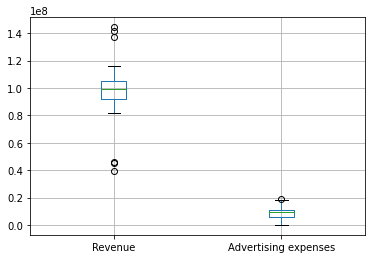

In [410]:
df.boxplot(column=['Revenue', 'Advertising expenses']).autoscale

<AxesSubplot:xlabel='Revenue', ylabel='Density'>

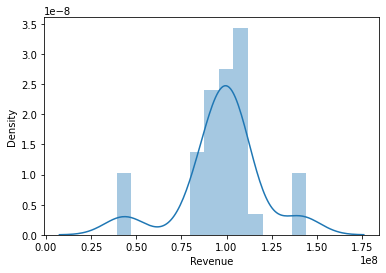

In [411]:
import seaborn as sns
sns.distplot(df['Revenue'].dropna())

In [412]:
# Полученные данные свидетельствуют о ненормальном распределении. Распространение ограничений на предприятия питания и торговли,
# связанных с COVID-19, отразилось на дистрибьюторах ресторанного оборудования. Период с апреля по июнь 2020 года охарактеризовался
# минимальной выручкой и отсутствием затрат на рекламу.
# Воспользуемся методом IQR.
IQR = df['Revenue'].quantile(0.75) - df['Revenue'].quantile(0.25)
lower_bound = df['Revenue'].quantile(0.25)-3*IQR
upper_bound = df['Revenue'].quantile(0.75)+3*IQR
print('lower_bound =', lower_bound)
print('upper_bound =', upper_bound)

lower_bound = 51183832.75
upper_bound = 146016556.75


In [425]:
# Для дальнейшего исследования заменим выбросы на среднее значение по столбцам.
mean = df['Revenue'].mean()
mean2 = df['Advertising expenses'].mean()
df.loc[((df.Revenue < lower_bound) | (df.Revenue > upper_bound)), 'Revenue'] = mean
df.loc[(df['Advertising expenses'] == 0), 'Advertising expenses'] = mean2
df.apply(lambda s: s.apply('{0:.2f}'.format))
df

,serial,Revenue,Advertising expenses
date,,,
2019-01-01,1,8.176490e+07,4.088244e+06
2019-02-01,2,8.545677e+07,5.127406e+06
2019-03-01,3,9.175335e+07,6.422734e+06
2019-04-01,4,9.918027e+07,7.138520e+06
2019-05-01,5,9.572599e+07,7.978079e+06
2019-06-01,6,9.533411e+07,9.120070e+06
2019-07-01,7,9.660804e+07,1.097602e+07
2019-08-01,8,9.747001e+07,1.169640e+07
2019-09-01,9,9.242813e+07,9.242813e+06


<AxesSubplot:xlabel='Advertising expenses', ylabel='Revenue'>

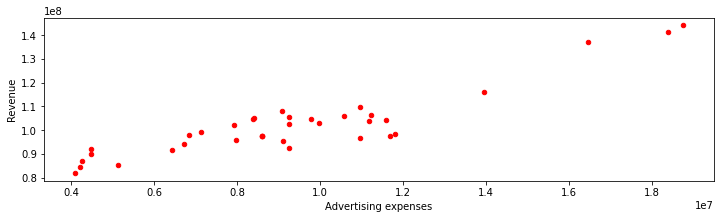

In [426]:
# Для оценки влияния рекламных затрат на выручку построим график разброса и матрицу корреляции.
df.plot.scatter (x = 'Advertising expenses', y = 'Revenue', figsize=(12,3), c = 'red')

<AxesSubplot:xlabel='date'>

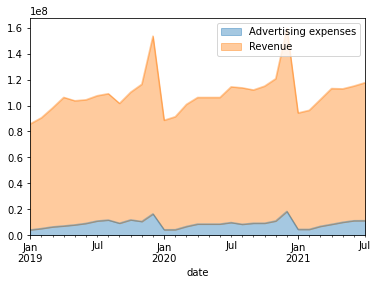

In [427]:
df[0:31].plot.area(y = ['Advertising expenses', 'Revenue'], alpha = 0.4, stacked=True)

                      Advertising expenses   Revenue
Advertising expenses              1.000000  0.910167
Revenue                           0.910167  1.000000


<AxesSubplot:>

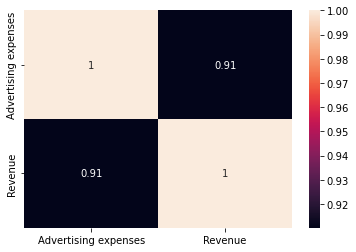

In [428]:
corr_matrix = df.loc[:,['Advertising expenses', 'Revenue']].corr()
print(corr_matrix)

# Используем тепловую карту для визуализации матрицы корреляции
sns.heatmap(corr_matrix, annot=True)

In [300]:
# Высокий коэффициент корреляции свидетельствуют о зависимости между этими переменными.
# Увеличение затрат на рекламу влечет за собой увеличение выручки. 

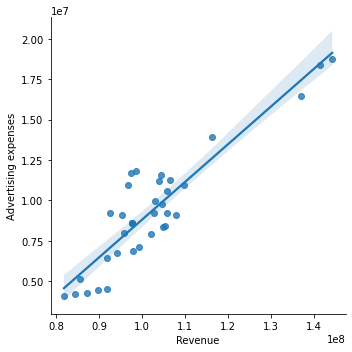

In [429]:
sns.lmplot(x='Revenue',
           y='Advertising expenses',
           data=df);

In [430]:
df

,serial,Revenue,Advertising expenses
date,,,
2019-01-01,1,8.176490e+07,4.088244e+06
2019-02-01,2,8.545677e+07,5.127406e+06
2019-03-01,3,9.175335e+07,6.422734e+06
2019-04-01,4,9.918027e+07,7.138520e+06
2019-05-01,5,9.572599e+07,7.978079e+06
2019-06-01,6,9.533411e+07,9.120070e+06
2019-07-01,7,9.660804e+07,1.097602e+07
2019-08-01,8,9.747001e+07,1.169640e+07
2019-09-01,9,9.242813e+07,9.242813e+06


In [253]:
# Из приведенного выше графика мы можем видеть, что существует положительная линейная зависимость между затратами на рекламу и
# выручкой компании. 

In [431]:
df.insert(0, 'serial', range(1, 1 + len(df)))
df.apply(lambda s: s.apply('{0:.2f}'.format))
df

ValueError: cannot insert serial, already exists

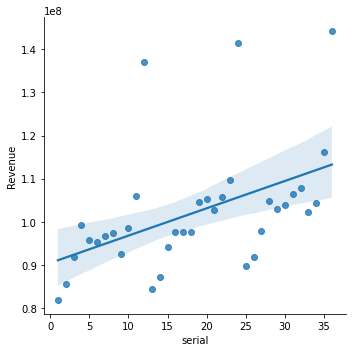

In [432]:
# Построим график линейной регресии для оценки зависимости выручки от даты, а также матрицу корреляции.
sns.lmplot(x='serial',
           y='Revenue',
           data=df);

In [433]:
corr_matrix = df.loc[:,['Advertising expenses', 'Revenue', 'serial']].corr()
print(corr_matrix)

                      Advertising expenses   Revenue    serial
Advertising expenses              1.000000  0.910167  0.350648
Revenue                           0.910167  1.000000  0.476032
serial                            0.350648  0.476032  1.000000


In [ ]:
# Проведенное исследование демонстрирует, что связь между датой и переменными выручки и рекламных затрат весьма расплывчатая.

In [ ]:
# Построим график временного ряда атрибута Revenue

<AxesSubplot:title={'center':'Dynamics of sales'}, xlabel='date', ylabel='Revenue'>

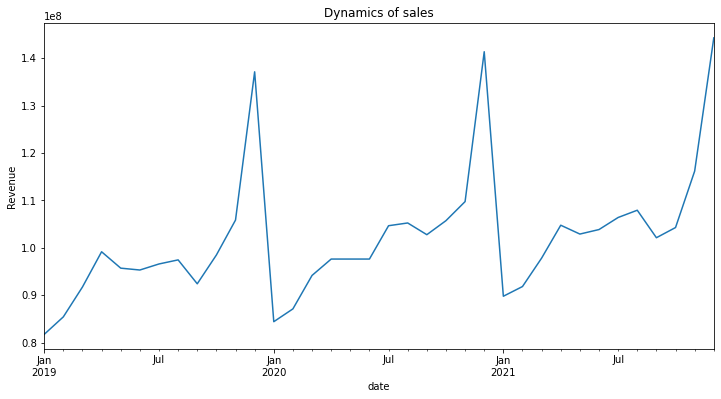

In [435]:
df['Revenue'].plot(figsize=(12,6), title='Dynamics of sales', xlabel='date', ylabel='Revenue')

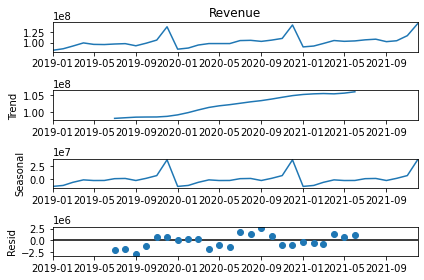

In [436]:
# Построим декомпозицию временного ряда. На графике явно прослеживается сезонность и тренд увеличения выручки с течением времени.
result = seasonal_decompose(df['Revenue'], model='add').plot()

In [447]:
df.to_csv('/Users/nastya/Documents/Projects/python/Dataset-test.csv')

In [449]:
from statsmodels.tsa.stattools import adfuller 
from numpy import log 
mydata = pd.read_csv('/Users/nastya/Documents/Projects/python/Dataset-test.csv', names = ['value'], header = 0)
res = adfuller(mydata.value.dropna()) 
print('Augmented Dickey-Fuller Statistic: %f' % res[0]) 
print('p-value: %f' % res[1]) 

Augmented Dickey-Fuller Statistic: -3.602699
p-value: 0.005710


In [451]:
auto_arima(df['Revenue']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -630.071
Date:                Sun, 20 Mar 2022   AIC                           1262.143
Time:                        22:12:18   BIC                           1263.698
Sample:                             0   HQIC                          1262.680
                                 - 36                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.463e+14   3.12e+13      7.897      0.000    1.85e+14    3.07e+14
===================================================================================
Ljung-Box (L1) (Q):                   3.71   Jarque-Bera (JB):                64.32
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -1.75
Prob(H) (two-sided):                  0.91   Kurtosis:                         8.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

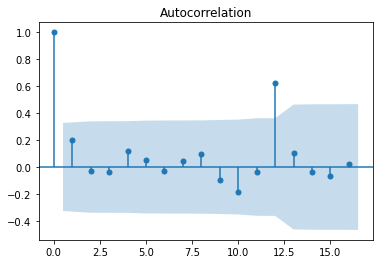

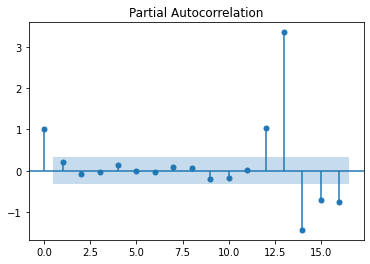

In [493]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['Revenue'])
plt.show()
plot_pacf(df['Revenue'])
pyplot.show()

In [ ]:
# Полученный график автокорреляции позволяет отвергнуть наличие сезонных колебаний. То, что корреляция показывает отрицательные
# значения говорит об отсутствии тренда.

In [452]:
#Несмотря на первоначальную оценку данных, тест Дики-Фуллера и запуск модели autoarima показали,
#что данный временной ряд является стационарным. Разделим данные на train/test и установим один (последний) год для тестироваия.
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

In [453]:
# Обучим модель ARIMA(0,1,0) на train['Revenue']
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train['Revenue'], order=(0,1,0))
results = model.fit(disp=False)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.Revenue   No. Observations:                   23
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -412.248
Method:                           css   S.D. of innovations       14722756.873
Date:                Sun, 20 Mar 2022   AIC                            828.497
Time:                        22:12:48   BIC                            830.768
Sample:                    02-01-2019   HQIC                           829.068
                         - 12-01-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.591e+06   3.07e+06      0.844      0.399   -3.43e+06    8.61e+06
==============================================================================
"""

In [454]:
#получим прогнозируемые значения
start = len(train)
end = len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename(' Predictions ARIMA(0, 1, 0)')
predictions

2021-01-01    1.439468e+08
2021-02-01    1.465377e+08
2021-03-01    1.491286e+08
2021-04-01    1.517195e+08
2021-05-01    1.543104e+08
2021-06-01    1.569014e+08
2021-07-01    1.594923e+08
2021-08-01    1.620832e+08
2021-09-01    1.646741e+08
2021-10-01    1.672650e+08
2021-11-01    1.698559e+08
2021-12-01    1.724468e+08
Freq: MS, Name:  Predictions ARIMA(0, 1, 0), dtype: float64

In [455]:
#Сравниваем результаты
for i in range (len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Revenue'][i]}")

predicted=143946790.2, expected=89805489.0
predicted=146537702.4, expected=91850788.0
predicted=149128614.7, expected=97844794.0
predicted=151719526.9, expected=104778133.0
predicted=154310439.1, expected=102914875.0
predicted=156901351.3, expected=103866156.0
predicted=159492263.5, expected=106409746.0
predicted=162083175.7, expected=107937525.0
predicted=164674088.0, expected=102142658.0
predicted=167265000.2, expected=104290946.0
predicted=169855912.4, expected=116192222.0
predicted=172446824.6, expected=144277673.0


[Text(0.5, 0, 'date'), Text(0, 0.5, 'Revenue')]

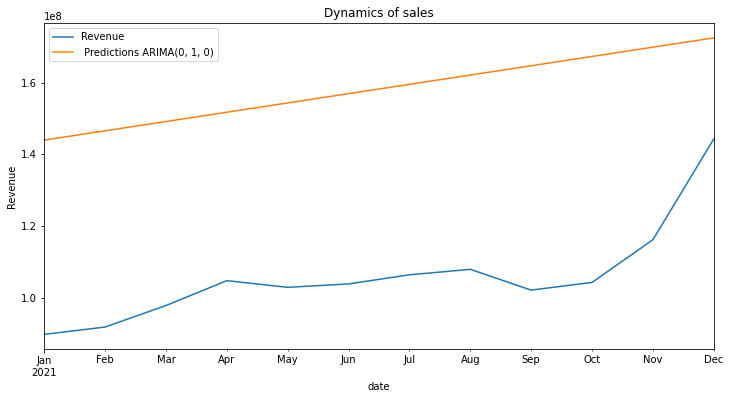

In [462]:
# Построим график прогнозируемых и известных значений
ax = test['Revenue'].plot(legend=True, figsize=(12,6), title = 'Dynamics of sales')
predictions.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel='date', ylabel='Revenue')

In [464]:
# Оценим качество модели с помощью MSE и RMSE
error=mean_squared_error(test['Revenue'], predictions)
print(f'ARIMA(0, 1, 0)MSE Error: {error:11.10}')

ARIMA(0, 1, 0)MSE Error: 2.792367411e+15


In [465]:
error=rmse(test['Revenue'], predictions)
print(f'ARIMA(0, 1,0)RMSE Error: {error:11.10}')

ARIMA(0, 1,0)RMSE Error: 52842855.82


In [470]:
from sklearn.model_selection import train_test_split
X = df.drop(['Revenue'],axis=1) 
Y = df['Revenue']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.20, random_state=0)
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [472]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression().fit(X_train , Y_train)
LR_Test_predict = linear_model.predict(X_test) 
LR_MAPE= MAPE(Y_test,LR_Test_predict)
print("MAPE: ",LR_MAPE)

MAPE:  2.1450457493538773


In [ ]:
# Полученные значения MSE и RMSE говорят о нам высокой ошибке и неточности прогноза.
# Причиной может быть неверно подобранная модель или недостаточных данных для прогноза.
# При этом значение MAPE равное 2% свидетельствует о том, что средняя разница между прогнозируемым значением и фактическим
# значением составляет 2%.

In [473]:
#Натренируем модель на полном датасете и предскажем на год вперед
model = ARIMA(df['Revenue'], order=(0,1,0))
results = model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.79955D+01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   1.800D+01
  F =   17.995502112479592     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.Revenue   No. Observations:                   35
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -629.843
Method:                           css   S.D. of innovations       15816489.283
Date:                Sun, 20 Mar 2022   AIC                           1263.685
Time:                        22:34:35   BIC                           1266.796
Sample:                    02-01-2019   HQIC                          1264.759
                         - 12-01-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.786e+06   2.67e+06      0.668      0.504   -3.45e+06    7.03e+06
==============================================================================
"""

In [483]:
fcast = results.predict(len(df),len(df)+12, typ='levels').rename('ARIMA(0, 1, 0)Forecast')
fcast

2022-01-01    1.460638e+08
2022-02-01    1.478498e+08
2022-03-01    1.496359e+08
2022-04-01    1.514220e+08
2022-05-01    1.532081e+08
2022-06-01    1.549941e+08
2022-07-01    1.567802e+08
2022-08-01    1.585663e+08
2022-09-01    1.603524e+08
2022-10-01    1.621385e+08
2022-11-01    1.639245e+08
2022-12-01    1.657106e+08
2023-01-01    1.674967e+08
Freq: MS, Name: ARIMA(0, 1, 0)Forecast, dtype: float64

<AxesSubplot:>

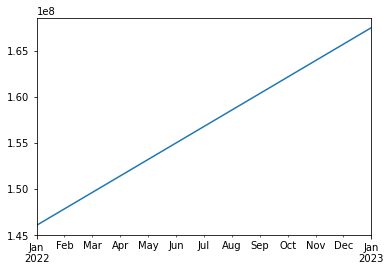

In [484]:
# Построим график предсказаний и график исходных данных
fcast.plot()

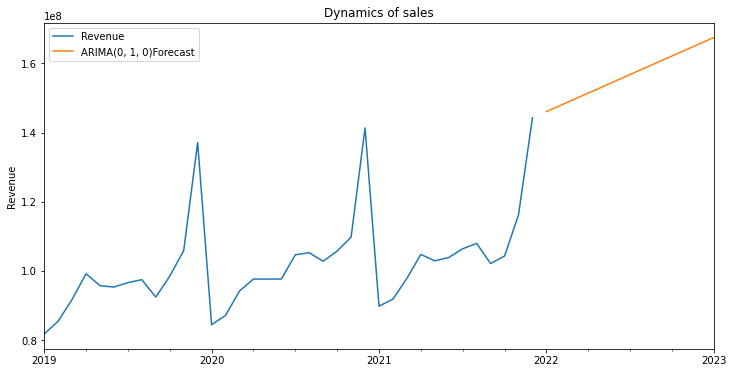

In [485]:
l=df['Revenue'].plot(figsize=(12,6), legend=True, title='Dynamics of sales', xlabel='', ylabel='Revenue')
fcast.plot(legend=True)
l.autoscale(axis='x', tight=True)